# Import libraries

In [66]:
##### base #####
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
##### sklearn #####
from sklearn.model_selection import train_test_split
##### torch ######
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, ConcatDataset, Dataset, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

# Setup

In [4]:
torch.cuda.is_available()

False

In [5]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


# Load and check MNIST dataset

In [6]:
# mean and std for MNIST dataset
mean, std = 0.1307, 0.3081

# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Load MNIST training and testing dataset
original_train_ds = torchvision.datasets.MNIST(root = 'data/', train = True, transform = transform, download = True)
original_test_ds = torchvision.datasets.MNIST(root = 'data/', train = False, transform = transform, download = True)

print('Train dataset:', len(original_train_ds))
print('Test dataset:', len(original_test_ds))

100%|██████████| 9.91M/9.91M [00:00<00:00, 42.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.22MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.65MB/s]

Train dataset: 60000
Test dataset: 10000


In [7]:
classes = original_train_ds.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [8]:
# data[a][b]: a is an image, b is its info where data[a][0]: data, data[a][1]: label
img_label = [original_train_ds[img][1] for img in range(len(original_train_ds))] # iterate through each image
label_count = dict(Counter(img_label))
print("Labels count:", label_count)

Labels count: {5: 5421, 0: 5923, 4: 5842, 1: 6742, 9: 5949, 2: 5958, 3: 6131, 6: 5918, 7: 6265, 8: 5851}


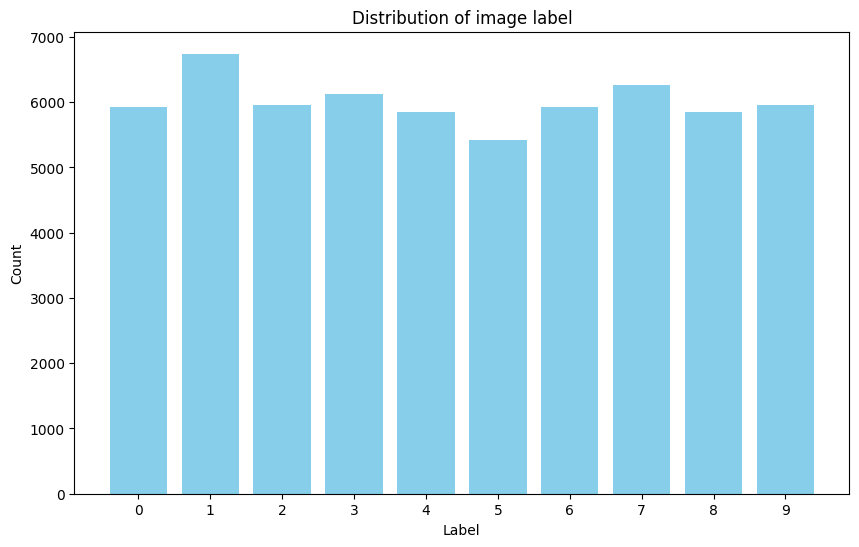

In [9]:
label_count = dict(sorted(label_count.items()))

plt.figure(figsize=(10,6))
plt.bar(label_count.keys(), label_count.values(), color = 'skyblue')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of image label')
plt.xticks(list(label_count.keys()))  # Ensure x-axis ticks are the keys
plt.show()

# 100 labeled MNIST dataset

In [10]:
def sample_100_digits(data):
    random.seed(42)  # For reproducibility
    labeled_indices = []

    # Loop through digits 0-9 and sample 10 examples per digit
    for digit in range(10):
        label_indices = torch.where(data.targets == digit)[0]
        subset_indices = random.sample(label_indices.tolist(), 10)
        labeled_indices.extend(subset_indices)

    # Create the labeled dataset (100 samples)
    labeled_dataset = Subset(data, labeled_indices)

    # Create the unlabeled dataset by removing the labeled indices
    all_indices = set(range(len(data)))
    unlabeled_indices = list(all_indices - set(labeled_indices))
    unlabeled_dataset = Subset(data, unlabeled_indices)

    return labeled_dataset, unlabeled_dataset

# Plotting the 100 samples
def plot_mnist_samples(dataset):
    fig, axes = plt.subplots(10, 10, figsize=(5, 5))
    axes = axes.flatten()

    for i, (img, label) in enumerate(dataset):
        axes[i].imshow(img[0], cmap='gray')  # Convert the 1-channel tensor to 2D image
        axes[i].axis('off')
        if i % 10 == 0:  # Mark the row with the digit label
            axes[i].set_ylabel(f'Digit {label}', rotation=0, labelpad=10, fontsize=10)

    plt.tight_layout()
    plt.show()

Labels count: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10}


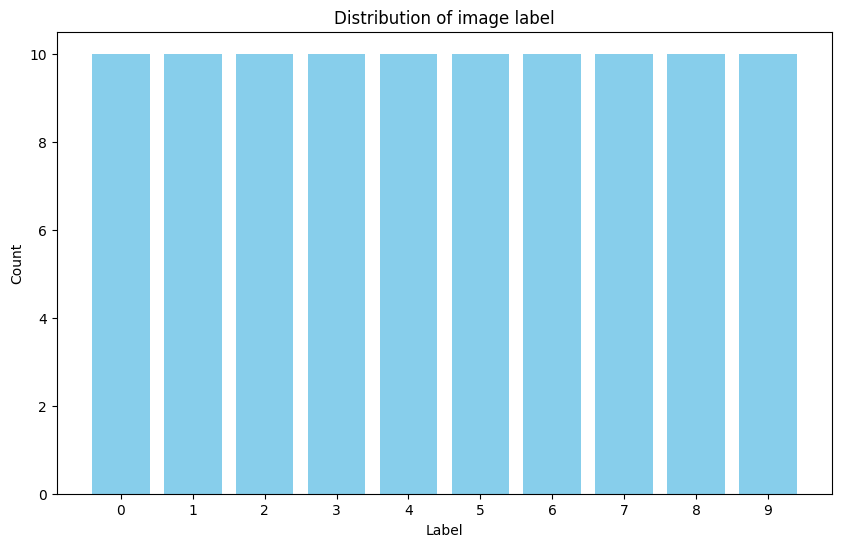

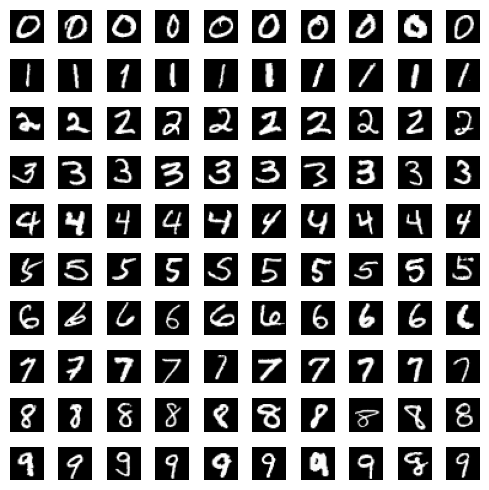

In [11]:
ds_100_labels, ds_unlabeled = sample_100_digits(original_train_ds)

img_label = [ds_100_labels[img][1] for img in range(len(ds_100_labels))]
label_count = dict(Counter(img_label))
print("Labels count:", label_count)

label_count = dict(sorted(label_count.items()))

plt.figure(figsize=(10,6))
plt.bar(label_count.keys(), label_count.values(), color = 'skyblue')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of image label')
plt.xticks(list(label_count.keys()))  # Ensure x-axis ticks are the keys
plt.show()

# plot 100 labeled data
plot_mnist_samples(ds_100_labels)

# Data agumentation

In [12]:
# transformer for data augmentation
def data_transformation(data, transformer_list = [], num_per_img = 10):
  """
  data augmentation applying each transforms for each original image,
  num_per_img is the number of images augmented from each original image for each transform
  """
  torch.manual_seed(42)
  augmented_data = []
  augmented_labels = []
  for i in range(len(data)):
    # Data augmentation
    img, label = data[i]
    augmented_data.append(img)
    augmented_labels.append(label)
    for t in transformer_list:
      # Generate new images from the original image
      for _ in range(num_per_img) :
        random.seed(42)
        new_img = t(img)
        augmented_data.append(new_img)
      # Update new labels
      augmented_labels.extend([label] * (num_per_img))
  augmented_data = torch.stack(augmented_data) # Concatenate a sequence of tensors
  augmented_labels = torch.tensor(augmented_labels)
  return TensorDataset(augmented_data, augmented_labels)

# Visualize the augmented data
def visualize_images(data, title='', rows = 10, cols =10 , fig_size = (5,5)):
  # function to visualize images

  plt.figure(figsize=fig_size)  # Set the figure size to 5x5
  for idx, img in enumerate(data):
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img[0].squeeze(), cmap='gray')
    plt.axis('off')
  plt.suptitle(title)
  plt.show()

Augmented data size: 5100 



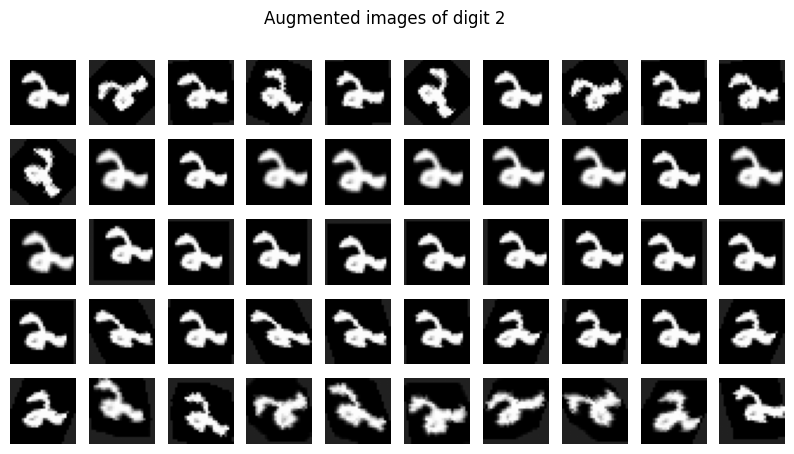

In [13]:
rotation45 = transforms.Compose([transforms.RandomRotation(45),
                                 transforms.Normalize(mean, std)])

crop_resize = transforms.Compose([transforms.RandomResizedCrop(28, scale=(0.8, 1), ratio = (1,1)),
                                  transforms.Normalize(mean, std)])

translation = transforms.Compose([transforms.RandomAffine(degrees = 0, translate=(0.1, 0.1)),
                                  transforms.Normalize(mean, std)])

shear30 = transforms.Compose([transforms.RandomAffine(0,shear=30),
                            transforms.Normalize(mean, std)])

transform_pipeline = transforms.Compose([transforms.RandomRotation(45),
                                          transforms.RandomResizedCrop(28, scale=(0.8, 1), ratio = (1,1)),
                                          transforms.RandomAffine(degrees = 0, translate=(0.1, 0.1)),
                                          transforms.RandomAffine(degrees = 0, shear = 30),
                                          transforms.Normalize(mean, std)])

transformer_list = [rotation45, crop_resize, translation, shear30, transform_pipeline]

data_aug = data_transformation(ds_100_labels, transformer_list, num_per_img = 10)
print("Augmented data size:", len(data_aug), "\n")

# select a digit from augmented data to plot
selected_digit = 2
targets_aug = []
for img in data_aug:
  targets_aug.append(img[1])
indices_label = [i for i in range(len(targets_aug)) if targets_aug[i] == selected_digit]

# visualize selected digit
visualize_images(Subset(data_aug, indices_label[:50]), title=f'Augmented images of digit {selected_digit}' , rows = 5, cols = 10, fig_size = (10,5))

In [14]:
# Get labels to stratify the split
labels = []
for i in range(len(data_aug)) :
  _, label = data_aug[i]
  labels.append(label)

# Split indices if the dataset is composed of images
train_idx, val_idx = train_test_split(list(range(len(labels))),
                                              test_size = 0.2,
                                              stratify = labels,
                                              random_state = 42,
                                              shuffle=True)

train_set = torch.utils.data.Subset(data_aug, train_idx)
val_set = torch.utils.data.Subset(data_aug, val_idx)

In [15]:
label_counts = Counter(int(train_set[i][1]) for i in range(len(train_set)))
print("Labels count for training set:", dict(label_counts))

Labels count for training set: {7: 408, 3: 408, 5: 408, 2: 408, 8: 408, 6: 408, 4: 408, 0: 408, 9: 408, 1: 408}


In [16]:
label_counts = Counter(int(val_set[i][1]) for i in range(len(val_set)))
print("Labels count for validaiton set:", dict(label_counts))

Labels count for validaiton set: {6: 102, 3: 102, 0: 102, 7: 102, 8: 102, 5: 102, 2: 102, 1: 102, 4: 102, 9: 102}


# Model architecture

In [17]:
def get_memory_params_model(model):
  # Model architecture
  print(model)
  print("Model memory allocation : {:.2e}".format(torch.cuda.memory_reserved(0) - torch.cuda.memory_allocated(0)))

  # Find total parameters and trainable parameters
  total_params = sum(p.numel() for p in model.parameters())
  print("{} total parameters.".format(total_params))
  total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print("{} training parameters.".format(total_trainable_params))

class CNN(nn.Module):
  def __init__(self):
    super().__init__() # always subclass
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding = "same") # conv layer 28x28x32
    self.batchnorm1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(2) # maxpooling 14x14x32

    self.conv2 = nn.Conv2d(32, 64, kernel_size=3) # first conv layer 12x12x64
    self.batchnorm2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(2) # maxpooling 6x6x64

    self.conv3 = nn.Conv2d(64, 128, kernel_size=3) # conv lazyer 4x4x128
    self.batchnorm3 = nn.BatchNorm2d(128)
    self.pool3 = nn.MaxPool2d(2) # maxpooling 2x2x128

    self.fc1 = nn.Linear(128*2*2, 192) # we have 10 probability classes to predict so 10 output features
    self.batchnorm4 = nn.BatchNorm1d(192)
    self.fc2 = nn.Linear(192, 64)
    self.batchnorm5 = nn.BatchNorm1d(64)
    self.fc3 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = F.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = F.relu(x)
    x = self.pool2(x)

    x = self.conv3(x)
    x = self.batchnorm3(x)
    x = F.relu(x)
    x = self.pool3(x)

    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.batchnorm4(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = self.batchnorm5(x)
    x = F.relu(x)
    x = self.fc3(x)

    return x

cnn = CNN().to(device)
get_memory_params_model(cnn)
print("\n\n")
summary(cnn, input_size=(1, 28, 28))

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=192, bias=True)
  (batchnorm4): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=192, out_features=64, bias=True)
  (batchnorm5): BatchNorm1d(64,

# Functions for training and evaluation phase

In [18]:
# Data Loader
def load_data(train, val, test, train_batch, val_batch, test_batch):
  torch.manual_seed(42)
  train_loader = torch.utils.data.DataLoader(train, batch_size=train_batch,
                                          shuffle=True, num_workers=0)
  val_loader = torch.utils.data.DataLoader(val, batch_size=val_batch,
                                         shuffle=False, num_workers=0)
  test_loader = torch.utils.data.DataLoader(test, batch_size=test_batch,
                                         shuffle=False, num_workers=0)
  return train_loader, val_loader, test_loader

def get_accuracy(y_true, y_pred):
    return int(np.sum(np.equal(y_true,y_pred))) / y_true.shape[0]

# class to implement Early Stopping
class EarlyStopping:
  """Early stops the training if validation loss doesn't improve after a given patience."""
  def __init__(self, patience=1, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_validation_loss = float('inf')

  def early_stop(self, validation_loss):
    if validation_loss < self.min_validation_loss:
      self.min_validation_loss = validation_loss
      self.counter = 0
    elif validation_loss > (self.min_validation_loss + self.min_delta):
      self.counter += 1
      print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      if self.counter >= self.patience:
        return True
    return False

# Train function
def train_model(model, epochs, train_loader, val_loader, optimizer_name = 'Adam', patience = 1, early_stopping = True, learning_rate = 0.001, device=None):
  torch.manual_seed(42)
  # Init
  output_fn = torch.nn.Softmax(dim=1) # we instantiate the softmax activation function for the output probabilities
  criterion = nn.CrossEntropyLoss() # we instantiate the loss function
  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate) # we instantiate Adam optimizer that takes as inputs the model parameters and learning rate

  loss_valid,acc_valid =[],[]
  loss_train,acc_train =[],[]

  # initialize the early_stopping object
  if early_stopping:
    early_stopper = EarlyStopping(patience=patience)

  for epoch in tqdm(range(epochs)):
    torch.manual_seed(42)
    # Training loop
    model.train() # always specify that the model is in training mode
    running_loss = 0.0 # init loss
    running_acc = 0.

    # Loop over batches returned by the data loader
    for idx, batch in enumerate(train_loader):

      # get the inputs; batch is a tuple of (inputs, labels)
      inputs, labels = batch
      inputs = inputs.to(device) # put the data on the same device as the model
      labels = labels.to(device)

      # put to zero the parameters gradients at each iteration to avoid accumulations
      optimizer.zero_grad()

      # forward pass + backward pass + update the model parameters
      out = model(x=inputs) # get predictions
      loss = criterion(out, labels) # compute loss
      loss.backward() # compute gradients
      optimizer.step() # update model parameters according to these gradients and our optimizer strategy

      # Iteration train metrics
      running_loss += loss.view(1).item()
      t_out = output_fn(out.detach()).cpu().numpy() # compute softmax (previously instantiated) and detach predictions from the model graph
      t_out=t_out.argmax(axis=1)  # the class with the highest energy is what we choose as prediction
      ground_truth = labels.cpu().numpy() # detach the labels from GPU device
      running_acc += get_accuracy(ground_truth, t_out)

    ### Epochs train metrics ###
    acc_train.append(running_acc/len(train_loader))
    loss_train.append(running_loss/len(train_loader))

    # compute loss and accuracy after an epoch on the train and valid set
    model.eval() # put the model in evaluation mode (this prevents the use of dropout layers for instance)

    ### VALIDATION DATA ###
    with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
      idx = 0
      for batch in val_loader:
        inputs,labels=batch
        inputs=inputs.to(device)
        labels=labels.to(device)
        if idx==0:
          t_out = model(x=inputs)
          t_loss = criterion(t_out, labels).view(1).item()
          t_out = output_fn(t_out).detach().cpu().numpy() # compute softmax (previously instantiated) and detach predictions from the model graph
          t_out=t_out.argmax(axis=1)  # the class with the highest energy is what we choose as prediction
          ground_truth = labels.cpu().numpy() # detach the labels from GPU device
        else:
          out = model(x=inputs)
          t_loss = np.hstack((t_loss,criterion(out, labels).item()))
          t_out = np.hstack((t_out,output_fn(out).argmax(axis=1).detach().cpu().numpy()))
          ground_truth = np.hstack((ground_truth,labels.detach().cpu().numpy()))
        idx+=1

      acc_valid.append(get_accuracy(ground_truth,t_out))
      loss_valid.append(np.mean(t_loss))

    print('| Epoch: {}/{} | Train: Loss {:.4f} Accuracy : {:.4f} '\
        '| Val: Loss {:.4f} Accuracy : {:.4f}\n'.format(epoch+1,epochs,loss_train[epoch],acc_train[epoch],loss_valid[epoch],acc_valid[epoch]))

    # early_stopping check if the validation loss has decresed, if yes, it will make a checkpoint of the current model
    if early_stopping:
      stop_bool = early_stopper.early_stop(loss_valid[epoch])
      if stop_bool:
        print("Early stopping")
        break

  # load the last checkpoint with the best model
  #if early_stopping:
    #model.load_state_dict(torch.load('checkpoint.pt'))

  return loss_train, loss_valid, acc_train, acc_valid

def plot_accuracy_loss(model_name, loss_train, loss_valid, acc_train, acc_valid) :
  """plot the accuracy and loss functions (for each epoch)
    early_stop_point = True: visualize the early stopping
  """

  fig = plt.figure(figsize = (12, 5))

  # --- Metrics plot
  def plot_metric(model_name, metric_train, metric_valid, metric_name) :
    """plot metrics of both datasets"""
    plt.plot(range(1, len(metric_train) + 1), metric_train, label='training set', marker='o', linestyle='solid',linewidth=1, markersize=6)
    plt.plot(range(1, len(metric_valid) + 1), metric_valid, label='validation set', marker='o', linestyle='solid',linewidth=1, markersize=6)
    # find position of lowest validation loss
    plt.title(f"{model_name}-model {metric_name}")
    plt.xlabel('#Epochs')
    plt.ylabel(f'{metric_name}')
    plt.legend(bbox_to_anchor=( 1., 1.))

  # Plot loss functions
  ax = fig.add_subplot(121)
  for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
  plot_metric(model_name, loss_train, loss_valid, "Loss")

  # Plot accuracy function
  ax = fig.add_subplot(122)
  for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
  plot_metric(model_name, acc_train, acc_valid, "Accuracy")

def test_model(model, test_loader):
  output_fn = torch.nn.Softmax(dim=1)
  model.eval()
  torch.manual_seed(42)
  with torch.no_grad():
    idx = 0
    for batch in test_loader:
      inputs,labels=batch
      inputs=inputs.to(device)
      labels=labels.to(device)
      if idx==0:
        t_out = model(x=inputs)
        t_out = output_fn(t_out).detach().cpu().numpy()
        t_out=t_out.argmax(axis=1)
        ground_truth = labels.detach().cpu().numpy()
      else:
        out = model(x=inputs)
        t_out = np.hstack((t_out,output_fn(out).argmax(axis=1).detach().cpu().numpy()))
        ground_truth = np.hstack((ground_truth,labels.detach().cpu().numpy()))
      idx+=1

  return get_accuracy(ground_truth,t_out)

# Training, Validating, Testing

In [19]:
# Load data for train, validate, test
train_ld, val_ld, test_ld = load_data(train_set, val_set, original_test_ds, 32, 32, 64)
num_epochs = 32

  2%|▏         | 1/64 [00:07<08:08,  7.75s/it]

| Epoch: 1/64 | Train: Loss 0.8191 Accuracy : 0.8198 | Val: Loss 0.3467 Accuracy : 0.9225



  3%|▎         | 2/64 [00:22<12:32, 12.13s/it]

| Epoch: 2/64 | Train: Loss 0.1983 Accuracy : 0.9614 | Val: Loss 0.2717 Accuracy : 0.9314



  5%|▍         | 3/64 [00:32<11:08, 10.96s/it]

| Epoch: 3/64 | Train: Loss 0.0663 Accuracy : 0.9917 | Val: Loss 0.1418 Accuracy : 0.9657



  6%|▋         | 4/64 [00:40<09:53,  9.89s/it]

| Epoch: 4/64 | Train: Loss 0.0271 Accuracy : 0.9980 | Val: Loss 0.1466 Accuracy : 0.9539



  8%|▊         | 5/64 [00:50<09:49, 10.00s/it]

| Epoch: 5/64 | Train: Loss 0.0108 Accuracy : 1.0000 | Val: Loss 0.0696 Accuracy : 0.9784



  9%|▉         | 6/64 [01:02<10:09, 10.52s/it]

| Epoch: 6/64 | Train: Loss 0.0052 Accuracy : 1.0000 | Val: Loss 0.0536 Accuracy : 0.9814



 11%|█         | 7/64 [01:10<09:05,  9.57s/it]

| Epoch: 7/64 | Train: Loss 0.0034 Accuracy : 1.0000 | Val: Loss 0.0506 Accuracy : 0.9824



 12%|█▎        | 8/64 [01:18<08:29,  9.09s/it]

| Epoch: 8/64 | Train: Loss 0.0025 Accuracy : 1.0000 | Val: Loss 0.0493 Accuracy : 0.9824



 14%|█▍        | 9/64 [01:25<07:48,  8.52s/it]

| Epoch: 9/64 | Train: Loss 0.0020 Accuracy : 1.0000 | Val: Loss 0.0485 Accuracy : 0.9824



 16%|█▌        | 10/64 [01:33<07:38,  8.49s/it]

| Epoch: 10/64 | Train: Loss 0.0016 Accuracy : 1.0000 | Val: Loss 0.0479 Accuracy : 0.9824



 17%|█▋        | 11/64 [01:42<07:25,  8.41s/it]

| Epoch: 11/64 | Train: Loss 0.0014 Accuracy : 1.0000 | Val: Loss 0.0474 Accuracy : 0.9824



 19%|█▉        | 12/64 [01:49<06:58,  8.04s/it]

| Epoch: 12/64 | Train: Loss 0.0011 Accuracy : 1.0000 | Val: Loss 0.0469 Accuracy : 0.9824



 20%|██        | 13/64 [01:57<06:48,  8.02s/it]

| Epoch: 13/64 | Train: Loss 0.0010 Accuracy : 1.0000 | Val: Loss 0.0466 Accuracy : 0.9833



 22%|██▏       | 14/64 [02:04<06:33,  7.88s/it]

| Epoch: 14/64 | Train: Loss 0.0008 Accuracy : 1.0000 | Val: Loss 0.0463 Accuracy : 0.9833



 23%|██▎       | 15/64 [02:12<06:27,  7.91s/it]

| Epoch: 15/64 | Train: Loss 0.0007 Accuracy : 1.0000 | Val: Loss 0.0461 Accuracy : 0.9833



 25%|██▌       | 16/64 [02:20<06:23,  7.98s/it]

| Epoch: 16/64 | Train: Loss 0.0006 Accuracy : 1.0000 | Val: Loss 0.0459 Accuracy : 0.9833



 27%|██▋       | 17/64 [02:28<06:02,  7.71s/it]

| Epoch: 17/64 | Train: Loss 0.0006 Accuracy : 1.0000 | Val: Loss 0.0459 Accuracy : 0.9833



 28%|██▊       | 18/64 [02:36<06:04,  7.93s/it]

| Epoch: 18/64 | Train: Loss 0.0005 Accuracy : 1.0000 | Val: Loss 0.0457 Accuracy : 0.9833



 30%|██▉       | 19/64 [02:43<05:45,  7.69s/it]

| Epoch: 19/64 | Train: Loss 0.0004 Accuracy : 1.0000 | Val: Loss 0.0456 Accuracy : 0.9833



 31%|███▏      | 20/64 [02:51<05:42,  7.77s/it]

| Epoch: 20/64 | Train: Loss 0.0004 Accuracy : 1.0000 | Val: Loss 0.0456 Accuracy : 0.9833



 33%|███▎      | 21/64 [03:00<05:45,  8.03s/it]

| Epoch: 21/64 | Train: Loss 0.0003 Accuracy : 1.0000 | Val: Loss 0.0455 Accuracy : 0.9833



 34%|███▍      | 22/64 [03:07<05:24,  7.72s/it]

| Epoch: 22/64 | Train: Loss 0.0003 Accuracy : 1.0000 | Val: Loss 0.0455 Accuracy : 0.9833



 36%|███▌      | 23/64 [03:15<05:18,  7.78s/it]

| Epoch: 23/64 | Train: Loss 0.0003 Accuracy : 1.0000 | Val: Loss 0.0455 Accuracy : 0.9833



 38%|███▊      | 24/64 [03:24<05:26,  8.17s/it]

| Epoch: 24/64 | Train: Loss 0.0003 Accuracy : 1.0000 | Val: Loss 0.0454 Accuracy : 0.9833



 39%|███▉      | 25/64 [03:33<05:26,  8.37s/it]

| Epoch: 25/64 | Train: Loss 0.0002 Accuracy : 1.0000 | Val: Loss 0.0454 Accuracy : 0.9833



 41%|████      | 26/64 [03:41<05:17,  8.36s/it]

| Epoch: 26/64 | Train: Loss 0.0002 Accuracy : 1.0000 | Val: Loss 0.0455 Accuracy : 0.9833



 42%|████▏     | 27/64 [03:48<04:55,  7.98s/it]

| Epoch: 27/64 | Train: Loss 0.0002 Accuracy : 1.0000 | Val: Loss 0.0455 Accuracy : 0.9833



 44%|████▍     | 28/64 [03:56<04:47,  7.99s/it]

| Epoch: 28/64 | Train: Loss 0.0002 Accuracy : 1.0000 | Val: Loss 0.0455 Accuracy : 0.9833



 45%|████▌     | 29/64 [04:04<04:35,  7.87s/it]

| Epoch: 29/64 | Train: Loss 0.0002 Accuracy : 1.0000 | Val: Loss 0.0455 Accuracy : 0.9833



 47%|████▋     | 30/64 [04:11<04:23,  7.74s/it]

| Epoch: 30/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0455 Accuracy : 0.9833



 48%|████▊     | 31/64 [04:19<04:16,  7.76s/it]

| Epoch: 31/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0455 Accuracy : 0.9824



 50%|█████     | 32/64 [04:26<04:01,  7.54s/it]

| Epoch: 32/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0456 Accuracy : 0.9824



 52%|█████▏    | 33/64 [04:34<03:56,  7.63s/it]

| Epoch: 33/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0456 Accuracy : 0.9824



 53%|█████▎    | 34/64 [04:41<03:43,  7.45s/it]

| Epoch: 34/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0457 Accuracy : 0.9824



 55%|█████▍    | 35/64 [04:48<03:39,  7.55s/it]

| Epoch: 35/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0457 Accuracy : 0.9824



 56%|█████▋    | 36/64 [04:56<03:33,  7.63s/it]

| Epoch: 36/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0458 Accuracy : 0.9824



 58%|█████▊    | 37/64 [05:03<03:21,  7.45s/it]

| Epoch: 37/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0458 Accuracy : 0.9833



 59%|█████▉    | 38/64 [05:12<03:26,  7.93s/it]

| Epoch: 38/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0459 Accuracy : 0.9833



 61%|██████    | 39/64 [05:19<03:10,  7.64s/it]

| Epoch: 39/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0460 Accuracy : 0.9833



 62%|██████▎   | 40/64 [05:27<03:05,  7.72s/it]

| Epoch: 40/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0460 Accuracy : 0.9833



 64%|██████▍   | 41/64 [05:35<02:57,  7.74s/it]

| Epoch: 41/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0461 Accuracy : 0.9833



 66%|██████▌   | 42/64 [05:42<02:47,  7.62s/it]

| Epoch: 42/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0461 Accuracy : 0.9833



 67%|██████▋   | 43/64 [05:50<02:41,  7.71s/it]

| Epoch: 43/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0462 Accuracy : 0.9833



 69%|██████▉   | 44/64 [05:57<02:29,  7.49s/it]

| Epoch: 44/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0463 Accuracy : 0.9833



 70%|███████   | 45/64 [06:05<02:25,  7.65s/it]

| Epoch: 45/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0463 Accuracy : 0.9833



 72%|███████▏  | 46/64 [06:13<02:16,  7.58s/it]

| Epoch: 46/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0464 Accuracy : 0.9833



 73%|███████▎  | 47/64 [06:20<02:09,  7.61s/it]

| Epoch: 47/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0464 Accuracy : 0.9833



 75%|███████▌  | 48/64 [06:28<02:03,  7.71s/it]

| Epoch: 48/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0465 Accuracy : 0.9833



 77%|███████▋  | 49/64 [06:35<01:52,  7.50s/it]

| Epoch: 49/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0466 Accuracy : 0.9833



 78%|███████▊  | 50/64 [06:43<01:46,  7.64s/it]

| Epoch: 50/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0466 Accuracy : 0.9833



 80%|███████▉  | 51/64 [06:50<01:37,  7.49s/it]

| Epoch: 51/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0467 Accuracy : 0.9833



 81%|████████▏ | 52/64 [06:58<01:31,  7.58s/it]

| Epoch: 52/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0467 Accuracy : 0.9833



 83%|████████▎ | 53/64 [07:07<01:26,  7.86s/it]

| Epoch: 53/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0468 Accuracy : 0.9833



 84%|████████▍ | 54/64 [07:14<01:16,  7.62s/it]

| Epoch: 54/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0469 Accuracy : 0.9833



 86%|████████▌ | 55/64 [07:22<01:09,  7.71s/it]

| Epoch: 55/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0470 Accuracy : 0.9833



 88%|████████▊ | 56/64 [07:29<01:00,  7.51s/it]

| Epoch: 56/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0470 Accuracy : 0.9833



 89%|████████▉ | 57/64 [07:37<00:53,  7.65s/it]

| Epoch: 57/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0472 Accuracy : 0.9833



 91%|█████████ | 58/64 [07:45<00:46,  7.73s/it]

| Epoch: 58/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0472 Accuracy : 0.9833



 92%|█████████▏| 59/64 [07:52<00:37,  7.53s/it]

| Epoch: 59/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0473 Accuracy : 0.9833



 94%|█████████▍| 60/64 [08:00<00:30,  7.65s/it]

| Epoch: 60/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0474 Accuracy : 0.9833



 95%|█████████▌| 61/64 [08:07<00:22,  7.47s/it]

| Epoch: 61/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0475 Accuracy : 0.9833



 97%|█████████▋| 62/64 [08:15<00:15,  7.59s/it]

| Epoch: 62/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0476 Accuracy : 0.9833



 98%|█████████▊| 63/64 [08:22<00:07,  7.68s/it]

| Epoch: 63/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0478 Accuracy : 0.9833



100%|██████████| 64/64 [08:30<00:00,  7.97s/it]

| Epoch: 64/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0478 Accuracy : 0.9833



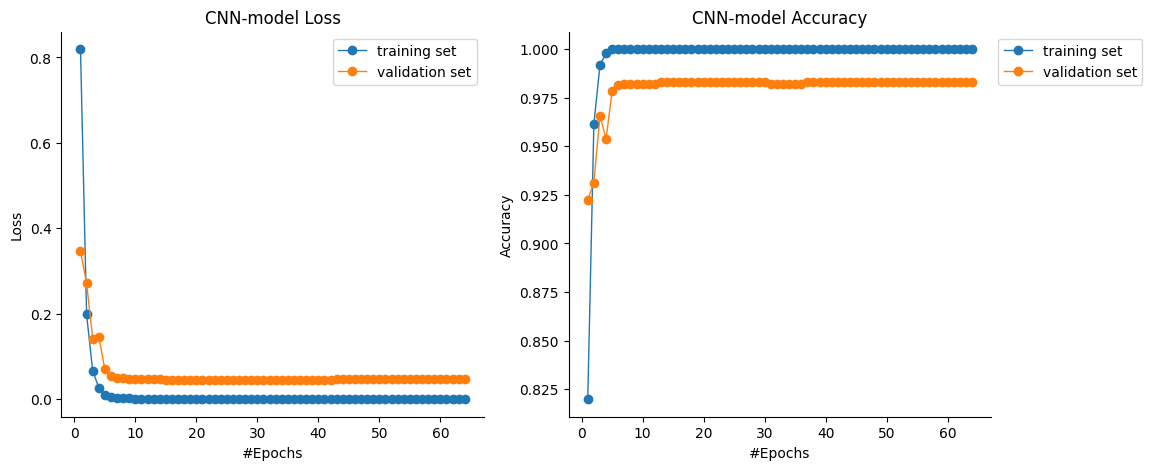

In [20]:
# train
loss_train, loss_valid, acc_train, acc_valid = train_model(cnn, num_epochs, train_ld, val_ld, optimizer_name='Adam', early_stopping = False, learning_rate = 0.001, device=device)
plot_accuracy_loss('CNN', loss_train, loss_valid, acc_train, acc_valid)

In [21]:
# test
print("Accuracy for CNN (data augmentation):", test_model(cnn, test_ld))

Accuracy for CNN (data augmentation): 0.9366


# Self-training/Pseudo-labelling

In [22]:
len(ds_unlabeled)

59900

We use the trained CNN
 the 100 labeled and augmented data:

In [51]:
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

def generate_pseudo_labels(model, dataloader, threshold=0.99, dataset_indices=None):
    model.eval()
    pseudo_imgs = []
    pseudo_labels = []
    pseudo_indices = []
    softmax = torch.nn.Softmax(dim=1)

    with torch.no_grad():
        for batch_idx, (img, _) in enumerate(dataloader):
            batch_start = batch_idx * dataloader.batch_size
            img = img.to(device)
            outputs = model(img)
            probs = softmax(outputs)
            max_probs, preds = torch.max(probs, dim=1)
            mask = max_probs > threshold

            selected_imgs = img[mask].cpu()
            selected_preds = preds[mask].cpu()

            pseudo_imgs.extend(selected_imgs)
            pseudo_labels.extend(selected_preds)

            # Get original dataset indices if provided
            if dataset_indices is not None:
                batch_indices = dataset_indices[batch_start:batch_start + len(img)]
                selected_indices = [batch_indices[i] for i in range(len(mask)) if mask[i]]
                pseudo_indices.extend(selected_indices)

    print(f"Pseudo-labeled: {len(pseudo_labels)} samples with confidence > {threshold}")
    return TensorDataset(torch.stack(pseudo_imgs), torch.tensor(pseudo_labels)), pseudo_indices

In [55]:
unlabeled_indices = list(range(len(ds_unlabeled)))
unlabeled_loader = torch.utils.data.DataLoader(ds_unlabeled, batch_size=128, shuffle=False)
pseudo_labeled_dataset, all_pseudo_indices = generate_pseudo_labels(cnn, unlabeled_loader, threshold=0.99, dataset_indices=unlabeled_indices) # set threshold to get high confidence pseudo

Pseudo-labeled: 44161 samples with confidence > 0.99


In [57]:
len(all_pseudo_indices) # confirm if index was stored correctly

44161

In [45]:
combined_dataset = torch.utils.data.ConcatDataset([data_aug, pseudo_labeled_dataset])
len(combined_dataset) # data-aug + high confidence label

49261

In [28]:
# You may re-split again if needed
labels_combined = [label for _, label in combined_dataset]
train_idx, val_idx = train_test_split(list(range(len(labels_combined))),
                                      test_size=0.2,
                                      stratify=labels_combined,
                                      random_state=42)

train_set_combined = torch.utils.data.Subset(combined_dataset, train_idx)
val_set_combined = torch.utils.data.Subset(combined_dataset, val_idx)

test_ld, val_ld, test_ld = load_data(train_set_combined, val_set_combined, original_test_ds, 32, 32, 64)

num_epochs = 32

In [29]:
cnn_pseudo = CNN().to(device)

  2%|▏         | 1/64 [00:13<14:34, 13.87s/it]

| Epoch: 1/64 | Train: Loss 0.7693 Accuracy : 0.8455 | Val: Loss 0.8946 Accuracy : 0.8953



  3%|▎         | 2/64 [00:27<14:00, 13.55s/it]

| Epoch: 2/64 | Train: Loss 0.1804 Accuracy : 0.9651 | Val: Loss 0.5685 Accuracy : 0.9177



  5%|▍         | 3/64 [00:41<14:09, 13.93s/it]

| Epoch: 3/64 | Train: Loss 0.0649 Accuracy : 0.9919 | Val: Loss 0.3124 Accuracy : 0.9552



  6%|▋         | 4/64 [00:55<13:46, 13.77s/it]

| Epoch: 4/64 | Train: Loss 0.0314 Accuracy : 0.9963 | Val: Loss 0.2782 Accuracy : 0.9428



  8%|▊         | 5/64 [01:08<13:26, 13.66s/it]

| Epoch: 5/64 | Train: Loss 0.0135 Accuracy : 0.9990 | Val: Loss 0.1155 Accuracy : 0.9894



  9%|▉         | 6/64 [01:21<13:07, 13.57s/it]

| Epoch: 6/64 | Train: Loss 0.0053 Accuracy : 1.0000 | Val: Loss 0.0748 Accuracy : 0.9926



 11%|█         | 7/64 [01:35<12:54, 13.60s/it]

| Epoch: 7/64 | Train: Loss 0.0034 Accuracy : 1.0000 | Val: Loss 0.0479 Accuracy : 0.9990



 12%|█▎        | 8/64 [01:49<12:37, 13.53s/it]

| Epoch: 8/64 | Train: Loss 0.0025 Accuracy : 1.0000 | Val: Loss 0.0375 Accuracy : 0.9992



 14%|█▍        | 9/64 [02:02<12:21, 13.49s/it]

| Epoch: 9/64 | Train: Loss 0.0020 Accuracy : 1.0000 | Val: Loss 0.0325 Accuracy : 0.9992



 16%|█▌        | 10/64 [02:15<12:07, 13.47s/it]

| Epoch: 10/64 | Train: Loss 0.0016 Accuracy : 1.0000 | Val: Loss 0.0292 Accuracy : 0.9992



 17%|█▋        | 11/64 [02:29<11:53, 13.46s/it]

| Epoch: 11/64 | Train: Loss 0.0013 Accuracy : 1.0000 | Val: Loss 0.0265 Accuracy : 0.9992



 19%|█▉        | 12/64 [02:47<12:51, 14.85s/it]

| Epoch: 12/64 | Train: Loss 0.0011 Accuracy : 1.0000 | Val: Loss 0.0243 Accuracy : 0.9992



 20%|██        | 13/64 [03:01<12:19, 14.51s/it]

| Epoch: 13/64 | Train: Loss 0.0010 Accuracy : 1.0000 | Val: Loss 0.0225 Accuracy : 0.9992



 22%|██▏       | 14/64 [03:15<11:57, 14.36s/it]

| Epoch: 14/64 | Train: Loss 0.0008 Accuracy : 1.0000 | Val: Loss 0.0209 Accuracy : 0.9993



 23%|██▎       | 15/64 [03:31<12:12, 14.96s/it]

| Epoch: 15/64 | Train: Loss 0.0007 Accuracy : 1.0000 | Val: Loss 0.0196 Accuracy : 0.9994



 25%|██▌       | 16/64 [03:44<11:35, 14.49s/it]

| Epoch: 16/64 | Train: Loss 0.0006 Accuracy : 1.0000 | Val: Loss 0.0184 Accuracy : 0.9994



 27%|██▋       | 17/64 [03:58<11:06, 14.19s/it]

| Epoch: 17/64 | Train: Loss 0.0006 Accuracy : 1.0000 | Val: Loss 0.0174 Accuracy : 0.9995



 28%|██▊       | 18/64 [04:11<10:40, 13.93s/it]

| Epoch: 18/64 | Train: Loss 0.0005 Accuracy : 1.0000 | Val: Loss 0.0165 Accuracy : 0.9995



 30%|██▉       | 19/64 [04:24<10:17, 13.71s/it]

| Epoch: 19/64 | Train: Loss 0.0004 Accuracy : 1.0000 | Val: Loss 0.0157 Accuracy : 0.9995



 31%|███▏      | 20/64 [04:38<09:59, 13.63s/it]

| Epoch: 20/64 | Train: Loss 0.0004 Accuracy : 1.0000 | Val: Loss 0.0149 Accuracy : 0.9995



 33%|███▎      | 21/64 [04:51<09:43, 13.58s/it]

| Epoch: 21/64 | Train: Loss 0.0003 Accuracy : 1.0000 | Val: Loss 0.0143 Accuracy : 0.9995



 34%|███▍      | 22/64 [05:05<09:28, 13.53s/it]

| Epoch: 22/64 | Train: Loss 0.0003 Accuracy : 1.0000 | Val: Loss 0.0136 Accuracy : 0.9995



 36%|███▌      | 23/64 [05:18<09:14, 13.52s/it]

| Epoch: 23/64 | Train: Loss 0.0003 Accuracy : 1.0000 | Val: Loss 0.0130 Accuracy : 0.9995



 38%|███▊      | 24/64 [05:33<09:13, 13.84s/it]

| Epoch: 24/64 | Train: Loss 0.0003 Accuracy : 1.0000 | Val: Loss 0.0125 Accuracy : 0.9995



 39%|███▉      | 25/64 [05:46<08:55, 13.74s/it]

| Epoch: 25/64 | Train: Loss 0.0002 Accuracy : 1.0000 | Val: Loss 0.0121 Accuracy : 0.9995



 41%|████      | 26/64 [06:00<08:43, 13.77s/it]

| Epoch: 26/64 | Train: Loss 0.0002 Accuracy : 1.0000 | Val: Loss 0.0116 Accuracy : 0.9994



 42%|████▏     | 27/64 [06:14<08:27, 13.70s/it]

| Epoch: 27/64 | Train: Loss 0.0002 Accuracy : 1.0000 | Val: Loss 0.0112 Accuracy : 0.9994



 44%|████▍     | 28/64 [06:27<08:10, 13.64s/it]

| Epoch: 28/64 | Train: Loss 0.0002 Accuracy : 1.0000 | Val: Loss 0.0108 Accuracy : 0.9994



 45%|████▌     | 29/64 [06:40<07:54, 13.57s/it]

| Epoch: 29/64 | Train: Loss 0.0002 Accuracy : 1.0000 | Val: Loss 0.0105 Accuracy : 0.9994



 47%|████▋     | 30/64 [06:54<07:40, 13.55s/it]

| Epoch: 30/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0102 Accuracy : 0.9994



 48%|████▊     | 31/64 [07:07<07:24, 13.48s/it]

| Epoch: 31/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0098 Accuracy : 0.9994



 50%|█████     | 32/64 [07:21<07:09, 13.42s/it]

| Epoch: 32/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0095 Accuracy : 0.9994



 52%|█████▏    | 33/64 [07:34<06:57, 13.47s/it]

| Epoch: 33/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0092 Accuracy : 0.9995



 53%|█████▎    | 34/64 [07:49<06:55, 13.85s/it]

| Epoch: 34/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0090 Accuracy : 0.9995



 55%|█████▍    | 35/64 [08:03<06:41, 13.85s/it]

| Epoch: 35/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0087 Accuracy : 0.9995



 56%|█████▋    | 36/64 [08:16<06:26, 13.82s/it]

| Epoch: 36/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0085 Accuracy : 0.9995



 58%|█████▊    | 37/64 [08:30<06:12, 13.78s/it]

| Epoch: 37/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0082 Accuracy : 0.9995



 59%|█████▉    | 38/64 [08:44<05:57, 13.73s/it]

| Epoch: 38/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0080 Accuracy : 0.9995



 61%|██████    | 39/64 [08:57<05:41, 13.67s/it]

| Epoch: 39/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0078 Accuracy : 0.9996



 62%|██████▎   | 40/64 [09:11<05:30, 13.78s/it]

| Epoch: 40/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0076 Accuracy : 0.9996



 64%|██████▍   | 41/64 [09:25<05:17, 13.81s/it]

| Epoch: 41/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0075 Accuracy : 0.9996



 66%|██████▌   | 42/64 [09:39<05:03, 13.82s/it]

| Epoch: 42/64 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0073 Accuracy : 0.9996



 67%|██████▋   | 43/64 [09:53<04:49, 13.79s/it]

| Epoch: 43/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0071 Accuracy : 0.9996



 69%|██████▉   | 44/64 [10:06<04:33, 13.66s/it]

| Epoch: 44/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0070 Accuracy : 0.9996



 70%|███████   | 45/64 [10:21<04:24, 13.91s/it]

| Epoch: 45/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0068 Accuracy : 0.9996



 72%|███████▏  | 46/64 [10:34<04:07, 13.76s/it]

| Epoch: 46/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0066 Accuracy : 0.9996



 73%|███████▎  | 47/64 [10:48<03:52, 13.67s/it]

| Epoch: 47/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0065 Accuracy : 0.9996



 75%|███████▌  | 48/64 [11:01<03:38, 13.64s/it]

| Epoch: 48/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0064 Accuracy : 0.9996



 77%|███████▋  | 49/64 [11:14<03:23, 13.55s/it]

| Epoch: 49/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0062 Accuracy : 0.9996



 78%|███████▊  | 50/64 [11:28<03:10, 13.62s/it]

| Epoch: 50/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0061 Accuracy : 0.9996



 80%|███████▉  | 51/64 [11:42<02:56, 13.59s/it]

| Epoch: 51/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0060 Accuracy : 0.9996



 81%|████████▏ | 52/64 [11:55<02:42, 13.55s/it]

| Epoch: 52/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0059 Accuracy : 0.9996



 83%|████████▎ | 53/64 [12:09<02:28, 13.54s/it]

| Epoch: 53/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0058 Accuracy : 0.9996



 84%|████████▍ | 54/64 [12:22<02:15, 13.51s/it]

| Epoch: 54/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0057 Accuracy : 0.9996



 86%|████████▌ | 55/64 [12:36<02:01, 13.53s/it]

| Epoch: 55/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0056 Accuracy : 0.9996



 88%|████████▊ | 56/64 [12:49<01:48, 13.51s/it]

| Epoch: 56/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0055 Accuracy : 0.9996



 89%|████████▉ | 57/64 [13:03<01:35, 13.68s/it]

| Epoch: 57/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0054 Accuracy : 0.9996



 91%|█████████ | 58/64 [13:18<01:23, 13.85s/it]

| Epoch: 58/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0053 Accuracy : 0.9996



 92%|█████████▏| 59/64 [13:32<01:09, 13.90s/it]

| Epoch: 59/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0052 Accuracy : 0.9996



 94%|█████████▍| 60/64 [13:45<00:55, 13.76s/it]

| Epoch: 60/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0051 Accuracy : 0.9996



 95%|█████████▌| 61/64 [13:58<00:40, 13.61s/it]

| Epoch: 61/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0050 Accuracy : 0.9996



 97%|█████████▋| 62/64 [14:12<00:27, 13.51s/it]

| Epoch: 62/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0049 Accuracy : 0.9996



 98%|█████████▊| 63/64 [14:25<00:13, 13.47s/it]

| Epoch: 63/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0049 Accuracy : 0.9996



100%|██████████| 64/64 [14:38<00:00, 13.73s/it]

| Epoch: 64/64 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0048 Accuracy : 0.9996



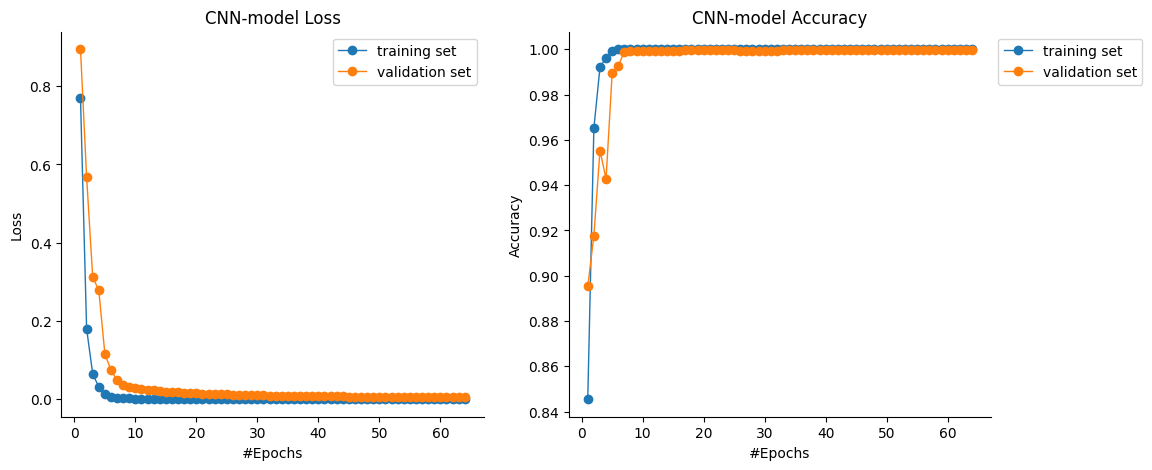

In [30]:
loss_train, loss_valid, acc_train, acc_valid = train_model(cnn_pseudo, num_epochs, train_ld, val_ld, optimizer_name='Adam', early_stopping = False, learning_rate = 0.001, device=device)
plot_accuracy_loss('CNN', loss_train, loss_valid, acc_train, acc_valid)

In [31]:
# test
print("Accuracy for CNN (data augmentation + pseudo-labeling):", test_model(cnn_pseudo, test_ld))

Accuracy for CNN (data augmentation + pseudo-labeling): 0.9412


Pseudo-labelling slightly improved from plain data augmentation

# Iterative pseudo-labelling

Previous data aug + pseudo-labelling data

In [39]:
len(combined_dataset)

49261

In [40]:
len(all_pseudo_indices)

44161

In [61]:
remaining_indices = sorted(set(range(len(ds_unlabeled))) - set(all_pseudo_indices))
len(remaining_indices)

15739

Use psuedo-laeblling and combined dataset from previous step

In [62]:
from torch.utils.data import TensorDataset, ConcatDataset, Subset
from sklearn.model_selection import train_test_split

num_iterations = 5
threshold = 0.99
num_epochs = 15

for iteration in range(num_iterations):
    print(f"\n### Iteration {iteration + 1} ###")

    # Compute remaining unlabeled indices
    remaining_indices = sorted(set(range(len(ds_unlabeled))) - set(all_pseudo_indices))
    print(f"Remaining unlabeled samples: {len(remaining_indices)}")

    # Stop if nothing left
    if not remaining_indices:
        print("All data has been pseudo-labeled.")
        break

    # Create a new DataLoader with only the remaining unlabeled samples
    remaining_subset = Subset(ds_unlabeled, remaining_indices)
    remaining_loader = DataLoader(remaining_subset, batch_size=128, shuffle=False)

    # Generate pseudo-labeled dataset and its corresponding indices
    new_pseudo_dataset, new_pseudo_indices = generate_pseudo_labels(
        model=cnn_pseudo,
        dataloader=remaining_loader,
        threshold=threshold,
        dataset_indices=remaining_indices
    )

    # If no new data, stop
    if len(new_pseudo_indices) == 0:
        print("No new high-confidence pseudo-labels this round.")
        break

    print("New unique pseudo-labeled samples to add:", len(new_pseudo_indices))

    # Update pseudo index tracker
    all_pseudo_indices.extend(new_pseudo_indices)
    all_pseudo_indices = list(set(all_pseudo_indices))  # Remove duplicates

    # Combine new data
    combined_dataset = ConcatDataset([combined_dataset, new_pseudo_dataset])
    print("Combined dataset size after merge:", len(combined_dataset))

    # Re-split the updated combined dataset
    labels_combined = [label for _, label in combined_dataset]
    train_idx, val_idx = train_test_split(
        list(range(len(labels_combined))),
        test_size=0.2,
        stratify=labels_combined,
        random_state=42
    )

    train_set_combined = Subset(combined_dataset, train_idx)
    val_set_combined = Subset(combined_dataset, val_idx)

    # Reload DataLoaders
    train_ld, val_ld, test_ld = load_data(train_set_combined, val_set_combined, original_test_ds, 32, 32, 64)

    # Retrain on the updated combined dataset
    loss_train, loss_valid, acc_train, acc_valid = train_model(
        cnn_pseudo, num_epochs, train_ld, val_ld,
        optimizer_name='Adam', early_stopping=False, learning_rate=0.001, device=device
    )

    # Evaluate on test
    test_acc = test_model(cnn_pseudo, test_ld)
    print(f"Test Accuracy after iteration {iteration + 1}: {test_acc:.4f}")

    # Lower threshold slightly for next iteration
    threshold -= 0.001
    print("Next threshold:", threshold)



### Iteration 1 ###
Remaining unlabeled samples: 15739
Pseudo-labeled: 7100 samples with confidence > 0.99
New unique pseudo-labeled samples to add: 7100
Combined dataset size after merge: 56361


  7%|▋         | 1/15 [01:28<20:39, 88.53s/it]

| Epoch: 1/15 | Train: Loss 0.0296 Accuracy : 0.9910 | Val: Loss 0.0185 Accuracy : 0.9933



 13%|█▎        | 2/15 [02:57<19:14, 88.84s/it]

| Epoch: 2/15 | Train: Loss 0.0124 Accuracy : 0.9962 | Val: Loss 0.0209 Accuracy : 0.9935



 20%|██        | 3/15 [04:24<17:33, 87.79s/it]

| Epoch: 3/15 | Train: Loss 0.0097 Accuracy : 0.9967 | Val: Loss 0.0146 Accuracy : 0.9959



 27%|██▋       | 4/15 [05:50<15:59, 87.20s/it]

| Epoch: 4/15 | Train: Loss 0.0081 Accuracy : 0.9975 | Val: Loss 0.0129 Accuracy : 0.9965



 33%|███▎      | 5/15 [07:17<14:30, 87.06s/it]

| Epoch: 5/15 | Train: Loss 0.0062 Accuracy : 0.9980 | Val: Loss 0.0176 Accuracy : 0.9944



 40%|████      | 6/15 [08:43<12:59, 86.63s/it]

| Epoch: 6/15 | Train: Loss 0.0065 Accuracy : 0.9978 | Val: Loss 0.0084 Accuracy : 0.9973



 47%|████▋     | 7/15 [10:08<11:30, 86.34s/it]

| Epoch: 7/15 | Train: Loss 0.0045 Accuracy : 0.9985 | Val: Loss 0.0097 Accuracy : 0.9973



 53%|█████▎    | 8/15 [11:36<10:07, 86.72s/it]

| Epoch: 8/15 | Train: Loss 0.0019 Accuracy : 0.9996 | Val: Loss 0.0085 Accuracy : 0.9981



 60%|██████    | 9/15 [13:03<08:41, 86.86s/it]

| Epoch: 9/15 | Train: Loss 0.0054 Accuracy : 0.9984 | Val: Loss 0.0269 Accuracy : 0.9929



 67%|██████▋   | 10/15 [14:30<07:14, 86.83s/it]

| Epoch: 10/15 | Train: Loss 0.0042 Accuracy : 0.9987 | Val: Loss 0.0174 Accuracy : 0.9950



 73%|███████▎  | 11/15 [15:56<05:46, 86.67s/it]

| Epoch: 11/15 | Train: Loss 0.0022 Accuracy : 0.9992 | Val: Loss 0.0073 Accuracy : 0.9975



 80%|████████  | 12/15 [17:23<04:20, 86.86s/it]

| Epoch: 12/15 | Train: Loss 0.0044 Accuracy : 0.9987 | Val: Loss 0.0082 Accuracy : 0.9978



 87%|████████▋ | 13/15 [18:49<02:53, 86.55s/it]

| Epoch: 13/15 | Train: Loss 0.0012 Accuracy : 0.9998 | Val: Loss 0.0076 Accuracy : 0.9977



 93%|█████████▎| 14/15 [20:15<01:26, 86.43s/it]

| Epoch: 14/15 | Train: Loss 0.0026 Accuracy : 0.9991 | Val: Loss 0.0180 Accuracy : 0.9955



100%|██████████| 15/15 [21:42<00:00, 86.86s/it]

| Epoch: 15/15 | Train: Loss 0.0027 Accuracy : 0.9991 | Val: Loss 0.0139 Accuracy : 0.9961



Test Accuracy after iteration 1: 0.9613
Next threshold: 0.989

### Iteration 2 ###
Remaining unlabeled samples: 8639
Pseudo-labeled: 5339 samples with confidence > 0.989
New unique pseudo-labeled samples to add: 5339
Combined dataset size after merge: 61700


  7%|▋         | 1/15 [01:35<22:22, 95.90s/it]

| Epoch: 1/15 | Train: Loss 0.0214 Accuracy : 0.9933 | Val: Loss 0.0108 Accuracy : 0.9968



 13%|█▎        | 2/15 [03:10<20:39, 95.33s/it]

| Epoch: 2/15 | Train: Loss 0.0064 Accuracy : 0.9976 | Val: Loss 0.0113 Accuracy : 0.9960



 20%|██        | 3/15 [04:47<19:08, 95.72s/it]

| Epoch: 3/15 | Train: Loss 0.0067 Accuracy : 0.9978 | Val: Loss 0.0114 Accuracy : 0.9960



 27%|██▋       | 4/15 [06:22<17:31, 95.55s/it]

| Epoch: 4/15 | Train: Loss 0.0041 Accuracy : 0.9986 | Val: Loss 0.0144 Accuracy : 0.9959



 33%|███▎      | 5/15 [07:57<15:53, 95.37s/it]

| Epoch: 5/15 | Train: Loss 0.0046 Accuracy : 0.9985 | Val: Loss 0.0189 Accuracy : 0.9945



 40%|████      | 6/15 [09:32<14:19, 95.46s/it]

| Epoch: 6/15 | Train: Loss 0.0045 Accuracy : 0.9987 | Val: Loss 0.0118 Accuracy : 0.9966



 47%|████▋     | 7/15 [11:07<12:41, 95.20s/it]

| Epoch: 7/15 | Train: Loss 0.0038 Accuracy : 0.9988 | Val: Loss 0.0137 Accuracy : 0.9965



 53%|█████▎    | 8/15 [12:43<11:07, 95.30s/it]

| Epoch: 8/15 | Train: Loss 0.0034 Accuracy : 0.9989 | Val: Loss 0.0140 Accuracy : 0.9958



 60%|██████    | 9/15 [14:18<09:31, 95.20s/it]

| Epoch: 9/15 | Train: Loss 0.0041 Accuracy : 0.9987 | Val: Loss 0.0184 Accuracy : 0.9950



 67%|██████▋   | 10/15 [15:54<07:57, 95.41s/it]

| Epoch: 10/15 | Train: Loss 0.0024 Accuracy : 0.9993 | Val: Loss 0.0118 Accuracy : 0.9964



 73%|███████▎  | 11/15 [17:29<06:22, 95.51s/it]

| Epoch: 11/15 | Train: Loss 0.0003 Accuracy : 0.9999 | Val: Loss 0.0114 Accuracy : 0.9968



 80%|████████  | 12/15 [19:08<04:49, 96.53s/it]

| Epoch: 12/15 | Train: Loss 0.0001 Accuracy : 1.0000 | Val: Loss 0.0100 Accuracy : 0.9972



 87%|████████▋ | 13/15 [20:44<03:12, 96.29s/it]

| Epoch: 13/15 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0100 Accuracy : 0.9971



 93%|█████████▎| 14/15 [22:21<01:36, 96.51s/it]

| Epoch: 14/15 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0100 Accuracy : 0.9972



100%|██████████| 15/15 [24:00<00:00, 96.02s/it]

| Epoch: 15/15 | Train: Loss 0.0000 Accuracy : 1.0000 | Val: Loss 0.0102 Accuracy : 0.9975



Test Accuracy after iteration 2: 0.9683
Next threshold: 0.988

### Iteration 3 ###
Remaining unlabeled samples: 3300
Pseudo-labeled: 1908 samples with confidence > 0.988
New unique pseudo-labeled samples to add: 1908
Combined dataset size after merge: 63608


  7%|▋         | 1/15 [01:37<22:44, 97.47s/it]

| Epoch: 1/15 | Train: Loss 0.0242 Accuracy : 0.9936 | Val: Loss 0.0193 Accuracy : 0.9947



 13%|█▎        | 2/15 [03:15<21:14, 98.08s/it]

| Epoch: 2/15 | Train: Loss 0.0079 Accuracy : 0.9974 | Val: Loss 0.0117 Accuracy : 0.9962



 20%|██        | 3/15 [04:56<19:52, 99.39s/it]

| Epoch: 3/15 | Train: Loss 0.0041 Accuracy : 0.9986 | Val: Loss 0.0165 Accuracy : 0.9947



 27%|██▋       | 4/15 [06:35<18:08, 98.98s/it]

| Epoch: 4/15 | Train: Loss 0.0060 Accuracy : 0.9980 | Val: Loss 0.0122 Accuracy : 0.9969



 33%|███▎      | 5/15 [08:13<16:27, 98.72s/it]

| Epoch: 5/15 | Train: Loss 0.0048 Accuracy : 0.9985 | Val: Loss 0.0149 Accuracy : 0.9958



 40%|████      | 6/15 [09:54<14:55, 99.55s/it]

| Epoch: 6/15 | Train: Loss 0.0045 Accuracy : 0.9985 | Val: Loss 0.0153 Accuracy : 0.9947



 47%|████▋     | 7/15 [11:32<13:11, 98.97s/it]

| Epoch: 7/15 | Train: Loss 0.0045 Accuracy : 0.9984 | Val: Loss 0.0123 Accuracy : 0.9965



 53%|█████▎    | 8/15 [13:11<11:32, 98.95s/it]

| Epoch: 8/15 | Train: Loss 0.0029 Accuracy : 0.9991 | Val: Loss 0.0145 Accuracy : 0.9955



 60%|██████    | 9/15 [14:51<09:55, 99.19s/it]

| Epoch: 9/15 | Train: Loss 0.0033 Accuracy : 0.9989 | Val: Loss 0.0163 Accuracy : 0.9949



 67%|██████▋   | 10/15 [16:28<08:13, 98.74s/it]

| Epoch: 10/15 | Train: Loss 0.0038 Accuracy : 0.9988 | Val: Loss 0.0221 Accuracy : 0.9943



 73%|███████▎  | 11/15 [18:07<06:34, 98.58s/it]

| Epoch: 11/15 | Train: Loss 0.0026 Accuracy : 0.9991 | Val: Loss 0.0179 Accuracy : 0.9950



 80%|████████  | 12/15 [19:44<04:54, 98.22s/it]

| Epoch: 12/15 | Train: Loss 0.0036 Accuracy : 0.9988 | Val: Loss 0.0168 Accuracy : 0.9950



 87%|████████▋ | 13/15 [21:20<03:15, 97.63s/it]

| Epoch: 13/15 | Train: Loss 0.0019 Accuracy : 0.9994 | Val: Loss 0.0138 Accuracy : 0.9950



 93%|█████████▎| 14/15 [22:58<01:37, 97.57s/it]

| Epoch: 14/15 | Train: Loss 0.0020 Accuracy : 0.9994 | Val: Loss 0.0276 Accuracy : 0.9930



100%|██████████| 15/15 [24:33<00:00, 98.23s/it]

| Epoch: 15/15 | Train: Loss 0.0036 Accuracy : 0.9990 | Val: Loss 0.0210 Accuracy : 0.9933



Test Accuracy after iteration 3: 0.9661
Next threshold: 0.987

### Iteration 4 ###
Remaining unlabeled samples: 1392
Pseudo-labeled: 487 samples with confidence > 0.987
New unique pseudo-labeled samples to add: 487
Combined dataset size after merge: 64095


  7%|▋         | 1/15 [01:38<22:59, 98.54s/it]

| Epoch: 1/15 | Train: Loss 0.0214 Accuracy : 0.9937 | Val: Loss 0.0113 Accuracy : 0.9967



 13%|█▎        | 2/15 [03:17<21:26, 99.00s/it]

| Epoch: 2/15 | Train: Loss 0.0058 Accuracy : 0.9980 | Val: Loss 0.0104 Accuracy : 0.9972



 20%|██        | 3/15 [04:55<19:41, 98.43s/it]

| Epoch: 3/15 | Train: Loss 0.0037 Accuracy : 0.9987 | Val: Loss 0.0134 Accuracy : 0.9964



 27%|██▋       | 4/15 [06:33<18:01, 98.30s/it]

| Epoch: 4/15 | Train: Loss 0.0044 Accuracy : 0.9986 | Val: Loss 0.0134 Accuracy : 0.9966



 33%|███▎      | 5/15 [08:11<16:21, 98.19s/it]

| Epoch: 5/15 | Train: Loss 0.0038 Accuracy : 0.9990 | Val: Loss 0.0170 Accuracy : 0.9954



 40%|████      | 6/15 [09:48<14:38, 97.61s/it]

| Epoch: 6/15 | Train: Loss 0.0040 Accuracy : 0.9988 | Val: Loss 0.0186 Accuracy : 0.9952



 47%|████▋     | 7/15 [11:25<12:59, 97.45s/it]

| Epoch: 7/15 | Train: Loss 0.0022 Accuracy : 0.9992 | Val: Loss 0.0188 Accuracy : 0.9947



 53%|█████▎    | 8/15 [13:02<11:22, 97.47s/it]

| Epoch: 8/15 | Train: Loss 0.0032 Accuracy : 0.9989 | Val: Loss 0.0181 Accuracy : 0.9949



 60%|██████    | 9/15 [14:41<09:46, 97.69s/it]

| Epoch: 9/15 | Train: Loss 0.0032 Accuracy : 0.9988 | Val: Loss 0.0170 Accuracy : 0.9952



 67%|██████▋   | 10/15 [16:18<08:08, 97.70s/it]

| Epoch: 10/15 | Train: Loss 0.0021 Accuracy : 0.9992 | Val: Loss 0.0154 Accuracy : 0.9959



 73%|███████▎  | 11/15 [17:56<06:31, 97.78s/it]

| Epoch: 11/15 | Train: Loss 0.0031 Accuracy : 0.9991 | Val: Loss 0.0186 Accuracy : 0.9948



 80%|████████  | 12/15 [19:34<04:53, 97.70s/it]

| Epoch: 12/15 | Train: Loss 0.0014 Accuracy : 0.9996 | Val: Loss 0.0170 Accuracy : 0.9954



 87%|████████▋ | 13/15 [21:11<03:14, 97.46s/it]

| Epoch: 13/15 | Train: Loss 0.0035 Accuracy : 0.9988 | Val: Loss 0.0185 Accuracy : 0.9951



 93%|█████████▎| 14/15 [22:48<01:37, 97.59s/it]

| Epoch: 14/15 | Train: Loss 0.0019 Accuracy : 0.9993 | Val: Loss 0.0169 Accuracy : 0.9950



100%|██████████| 15/15 [24:26<00:00, 97.78s/it]

| Epoch: 15/15 | Train: Loss 0.0018 Accuracy : 0.9995 | Val: Loss 0.0207 Accuracy : 0.9945



Test Accuracy after iteration 4: 0.9716
Next threshold: 0.986

### Iteration 5 ###
Remaining unlabeled samples: 905
Pseudo-labeled: 363 samples with confidence > 0.986
New unique pseudo-labeled samples to add: 363
Combined dataset size after merge: 64458


  7%|▋         | 1/15 [01:37<22:47, 97.70s/it]

| Epoch: 1/15 | Train: Loss 0.0182 Accuracy : 0.9948 | Val: Loss 0.0132 Accuracy : 0.9966



 13%|█▎        | 2/15 [03:15<21:09, 97.65s/it]

| Epoch: 2/15 | Train: Loss 0.0049 Accuracy : 0.9985 | Val: Loss 0.0091 Accuracy : 0.9974



 20%|██        | 3/15 [04:52<19:28, 97.40s/it]

| Epoch: 3/15 | Train: Loss 0.0017 Accuracy : 0.9995 | Val: Loss 0.0120 Accuracy : 0.9973



 27%|██▋       | 4/15 [06:35<18:14, 99.49s/it]

| Epoch: 4/15 | Train: Loss 0.0038 Accuracy : 0.9986 | Val: Loss 0.0162 Accuracy : 0.9953



 33%|███▎      | 5/15 [08:18<16:47, 100.75s/it]

| Epoch: 5/15 | Train: Loss 0.0043 Accuracy : 0.9985 | Val: Loss 0.0150 Accuracy : 0.9958



 40%|████      | 6/15 [09:59<15:07, 100.88s/it]

| Epoch: 6/15 | Train: Loss 0.0026 Accuracy : 0.9990 | Val: Loss 0.0144 Accuracy : 0.9957



 47%|████▋     | 7/15 [12:00<14:21, 107.69s/it]

| Epoch: 7/15 | Train: Loss 0.0020 Accuracy : 0.9994 | Val: Loss 0.0152 Accuracy : 0.9951



 53%|█████▎    | 8/15 [13:42<12:19, 105.65s/it]

| Epoch: 8/15 | Train: Loss 0.0027 Accuracy : 0.9991 | Val: Loss 0.0196 Accuracy : 0.9946



 60%|██████    | 9/15 [15:27<10:32, 105.39s/it]

| Epoch: 9/15 | Train: Loss 0.0028 Accuracy : 0.9992 | Val: Loss 0.0255 Accuracy : 0.9940



 67%|██████▋   | 10/15 [17:28<09:11, 110.22s/it]

| Epoch: 10/15 | Train: Loss 0.0027 Accuracy : 0.9993 | Val: Loss 0.0195 Accuracy : 0.9952



 73%|███████▎  | 11/15 [19:30<07:36, 114.03s/it]

| Epoch: 11/15 | Train: Loss 0.0022 Accuracy : 0.9994 | Val: Loss 0.0176 Accuracy : 0.9957



 80%|████████  | 12/15 [21:15<05:33, 111.19s/it]

| Epoch: 12/15 | Train: Loss 0.0025 Accuracy : 0.9993 | Val: Loss 0.0183 Accuracy : 0.9946



 87%|████████▋ | 13/15 [22:58<03:37, 108.70s/it]

| Epoch: 13/15 | Train: Loss 0.0020 Accuracy : 0.9995 | Val: Loss 0.0169 Accuracy : 0.9953



 93%|█████████▎| 14/15 [24:38<01:46, 106.08s/it]

| Epoch: 14/15 | Train: Loss 0.0006 Accuracy : 0.9998 | Val: Loss 0.0227 Accuracy : 0.9947



100%|██████████| 15/15 [26:15<00:00, 105.01s/it]

| Epoch: 15/15 | Train: Loss 0.0024 Accuracy : 0.9993 | Val: Loss 0.0201 Accuracy : 0.9955



Test Accuracy after iteration 5: 0.9718
Next threshold: 0.985


In [65]:
print(f"Iterative pseudo-labelling accuracy {num_iterations}: {test_model(cnn_pseudo, test_ld)}")

Iterative pseudo-labelling accuracy 5: 0.9718


# t-SNE visualization of pseudo-labelling + data augmentation CNN features

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


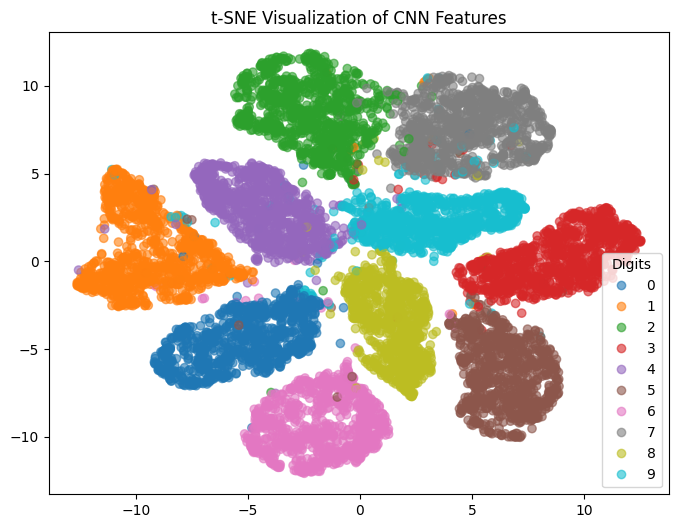

In [63]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

# 1. Collect features from encoder
features = []
labels = []
cnn_pseudo.eval()  # Switch model to evaluation mode
with torch.no_grad():
    for images, targets in test_ld:  # test_ld is your test data loader
        images = images.to(device)
        out = cnn_pseudo(images)  # Get model output (features)
        features.append(out.cpu())  # Move to CPU
        labels.append(targets)  # Store the true labels

# Concatenate all features and labels into single tensors
features = torch.cat(features).numpy()  # Convert to numpy
labels = torch.cat(labels).numpy()

# 2. Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(features)

# 3. Plot the t-SNE results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title("t-SNE Visualization of CNN Features")
plt.show()

In [67]:
def plot_confusion_matrix(model, test_loader, device, class_names=None):
    output_fn = torch.nn.Softmax(dim=1)
    model.eval()
    torch.manual_seed(42)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(x=inputs)
            preds = output_fn(outputs).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", linewidths=0.5,
            xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

Classification Report:
              precision    recall  f1-score   support

    0 - zero       0.96      0.99      0.98       980
     1 - one       0.95      0.99      0.97      1135
     2 - two       0.98      0.95      0.97      1032
   3 - three       0.98      0.98      0.98      1010
    4 - four       0.97      0.98      0.98       982
    5 - five       0.99      0.98      0.98       892
     6 - six       0.99      0.98      0.98       958
   7 - seven       0.93      0.98      0.95      1028
   8 - eight       0.99      0.97      0.98       974
    9 - nine       0.98      0.91      0.94      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



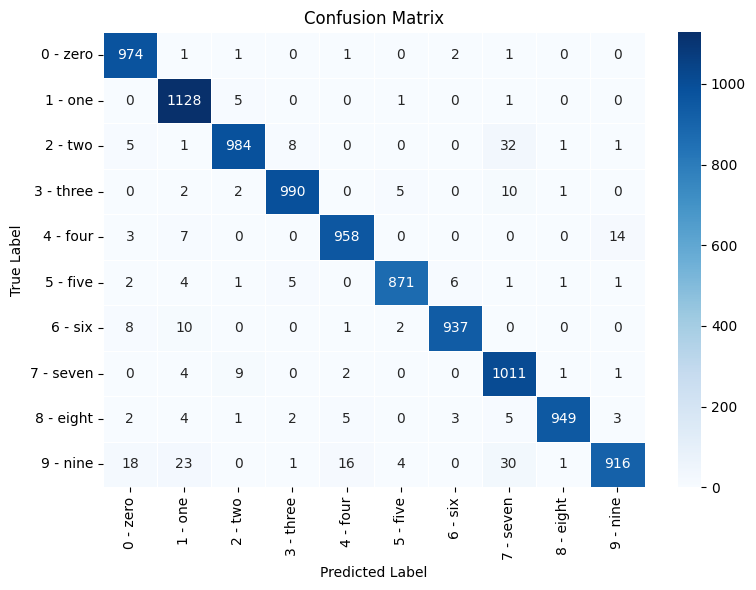

In [68]:
plot_confusion_matrix(cnn_pseudo, test_ld, device=device, class_names=original_train_ds.classes)